In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
df=pd.read_csv("../DATA/Frozen_Dessert_Production.csv")

In [24]:
df.head()


,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [34]:
df=df.set_index('DATE')

In [41]:
df.columns=["Production"]

In [43]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


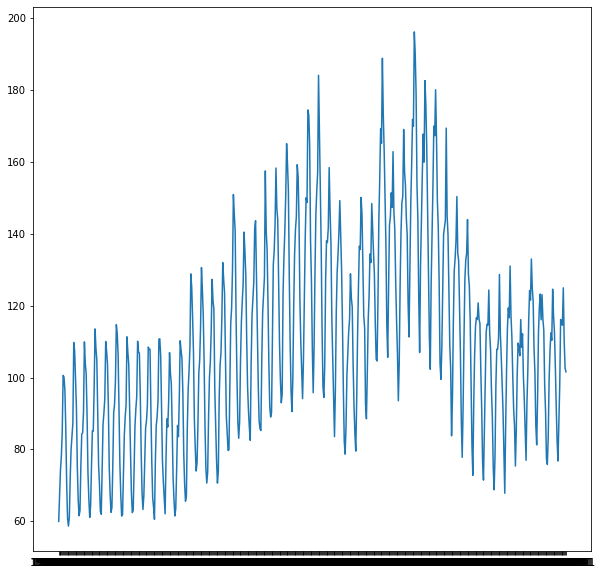

In [51]:
plt.figure(figsize=(10,10))
plt.plot(df)

In [52]:
len(df)

573

In [125]:
req_data=24
train_data=df[:-req_data]
test_data=df[-req_data:]

In [126]:
len(test_data)

24

In [127]:
train_data

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2017-05-01,116.0635
2017-06-01,123.0870
2017-07-01,116.2639


In [128]:
from sklearn.preprocessing import MinMaxScaler

In [129]:
scale=MinMaxScaler()

In [130]:
train_scaled=scale.fit_transform(train_data)
test_scaled=scale.transform(test_data)

In [131]:
train_scaled.size
test_scaled.size

24

In [73]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [92]:
generator=TimeseriesGenerator(data=train_scaled,targets=train_scaled,length=18,batch_size=1)

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [97]:
model= Sequential()

model.add(LSTM(100,activation='relu'))

model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')

In [98]:
early_Stop= EarlyStopping(monitor='val_loss', patience=2)

In [100]:
generator_val= TimeseriesGenerator(test_scaled,test_scaled,batch_size=1,length=18)

In [101]:
model.fit_generator(generator,epochs=20,validation_data=generator_val, callbacks=early_Stop)

Epoch 1/20


C:\Users\sandy\AppData\Local\Temp/ipykernel_1248/4103661039.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,validation_data=generator_val, callbacks=early_Stop)


531/531 [==============================] - 4s 5ms/step - loss: 0.0243 - val_loss: 0.0049
Epoch 2/20
531/531 [==============================] - 3s 5ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 3/20
531/531 [==============================] - 2s 5ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 4/20
531/531 [==============================] - 2s 5ms/step - loss: 0.0033 - val_loss: 0.0023


In [104]:
loss=pd.DataFrame(model.history.history)

<AxesSubplot:>

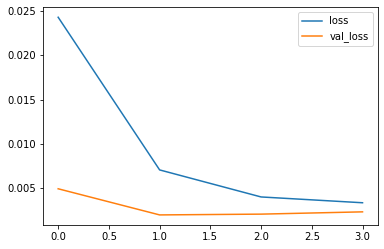

In [105]:
loss.plot()

In [107]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [132]:
test_predictions = []

first_eval_batch = train_scaled[-18:]
current_batch = first_eval_batch.reshape((1, 18, 1))

for i in range(len(test_data)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [140]:
first_eval_batch.shape

(18, 1)

In [112]:
prediction= scale.inverse_transform(test_predictions)

In [133]:
test_data["prediction"]=prediction

C:\Users\sandy\AppData\Local\Temp/ipykernel_1248/4228638014.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["prediction"]=prediction


In [134]:
test_data

,Production,prediction
DATE,,
2017-10-01,90.4732,89.554602
2017-11-01,77.4378,83.846925
2017-12-01,75.8118,86.113662
2018-01-01,83.4343,95.491674
2018-02-01,99.4899,105.935465
2018-03-01,107.3152,114.191013
2018-04-01,112.4309,119.630057
2018-05-01,110.3544,121.793810
2018-06-01,124.5841,119.489029


<AxesSubplot:xlabel='DATE'>

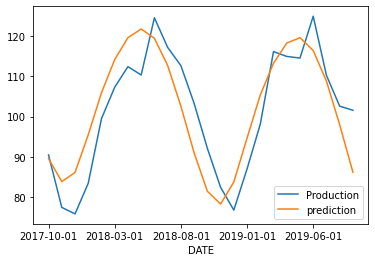

In [135]:
test_data.plot()

In [136]:
from sklearn.metrics import mean_squared_error

In [139]:
np.sqrt(mean_squared_error(test_data['Production'],test_data['prediction']))

7.994315197846205